In [20]:
import torch as ch
import torch.nn as nn
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt
from collections import OrderedDict
import oyaml as yaml
import json
from pprint import pprint
import os
import copy
import pandas as pd
import seaborn as sns
from torch.quantization import quantize_fx
import torchvision
from torch import Tensor
from tbparse import SummaryReader

# Config code

This code generates the config files in the required format for specified architectures at a given ceiling threshold. More specifically:
1. For a given architecture and compression factor, it calculates which feature maps need to be compressed and what the projection dimension needs to be in that case.
2. It generates dicts of the structure expected in the code specifying the locations in which to inser projection layers, and their respective dimensions.
3. It automatically generates a sequence of configs, one for each newly added projection layer.

In [21]:
def k_from_size(xshape, size):
    shape = (xshape[0], xshape[1]*xshape[2])
    k = np.floor(size / (shape[1]))
    return k

def size_from_k(xshape, k):
    shape = (xshape[0], xshape[1]*xshape[2])
    return k*(shape[1])


In [28]:
def plot_fm_sizes(sizes, arch, threshold_fraction):

    n = len(sizes)
    x = list(range(n))

    df = pd.DataFrame({"x":x, "size":sizes})
    g = sns.catplot(
        data=df, kind="bar",
        x="x", y="size",
        ci="sd", palette="dark", alpha=.6, height=6
    )
    g.despine(left=True)
    g.set_axis_labels("Feature Map", "feature map elements")
    g.fig.suptitle(arch)

    ax1 = g.axes.flatten()
    ax1[0].axhline(threshold_fraction*np.max(sizes), ls='--', color = 'b')

In [29]:
##########################
###### For VGG ###########
##########################

def generate_vgg_ceiling_sketch_dicts(feature_map_names, 
                                      sizes, 
                                      shapes, 
                                      threshold_fraction, 
                                      first_unsketched_idx,
                                      return_new_sizes=False):

    threshold = np.max(sizes)*threshold_fraction
    ks = {}
    compressed_size = 0
    total_size = 0
    ks[f'sketch_dicts'] = OrderedDict({})
    ks[f'compression_ratios'] = {}

    max_unsketched_size = 0
    for lay_idx, lay_size in enumerate(sizes[first_unsketched_idx:]):
        max_unsketched_size = np.maximum(max_unsketched_size, lay_size)

    threshold = np.maximum(max_unsketched_size, threshold)

    new_sizes = []
    for lay_idx, lay_size in enumerate(sizes):
        if lay_size>threshold and int(k_from_size(shapes[lay_idx], threshold))<shapes[lay_idx][0]:
            v = (shapes[lay_idx][0], int(k_from_size(shapes[lay_idx], threshold)))
            if feature_map_names[lay_idx][0] in ks[f'sketch_dicts']:
                ks[f'sketch_dicts'][feature_map_names[lay_idx][0]][feature_map_names[lay_idx][1]] = v
            else:
                ks[f'sketch_dicts'][feature_map_names[lay_idx][0]] = OrderedDict({feature_map_names[lay_idx][1]: v})
            new_lay_size = size_from_k(shapes[lay_idx], v[1])
            
        else:
            new_lay_size = lay_size
        new_sizes.append(new_lay_size)
        compressed_size += new_lay_size
        total_size+= lay_size
# 
    ks[f'compression_ratios']['total_compression_ratio'] = str(np.round(1/(compressed_size/total_size),1))+'x'
    ks[f'compression_ratios']['ceiling_compression_ratio'] = str(np.round(1/(threshold/np.max(sizes)), 1))+'x'
    if return_new_sizes:
        return ks, new_sizes
    else:
        return ks


###########################################
##### For resnet ###########
###########################################

def generate_resnet_ceiling_sketch_dicts(feature_map_names, 
                                         sizes, 
                                         shapes, 
                                         threshold_fraction, 
                                         first_unsketched_idx,
                                         return_new_sizes=False):


    threshold = np.max(sizes)*threshold_fraction
    ks = {}
    compressed_size = 0
    total_size = 0
    ks[f'sketch_dicts'] = OrderedDict({})
    ks[f'compression_ratios'] = {}

    max_unsketched_size = 0

    for lay_idx, lay_size in enumerate(sizes[first_unsketched_idx:]):
        max_unsketched_size = np.maximum(max_unsketched_size, lay_size)

    threshold = np.maximum(max_unsketched_size, threshold)
    new_sizes = []
    for lay_idx, lay_size in enumerate(sizes):
        if lay_size>threshold and int(k_from_size(shapes[lay_idx], threshold))<shapes[lay_idx][0]:
            v = (shapes[lay_idx][0], int(k_from_size(shapes[lay_idx], threshold)))
            section = feature_map_names[lay_idx][0][0]
            section_idx = feature_map_names[lay_idx][0][1][0]
            layer_name = feature_map_names[lay_idx][0][1][1]
            if section not in ks[f'sketch_dicts']:
                ks[f'sketch_dicts'][section] = []
            ks[f'sketch_dicts'][section].append( (section_idx, OrderedDict({layer_name:v})) )
            new_lay_size = size_from_k(shapes[lay_idx], v[1])
            
        else:
            new_lay_size = lay_size
        new_sizes.append(new_lay_size)
        compressed_size += new_lay_size
        total_size+= lay_size
 
    ks[f'compression_ratios']['total_compression_ratio'] = str(np.round(1/(compressed_size/total_size),1))+'x'
    ks[f'compression_ratios']['ceiling_compression_ratio'] = str(np.round(1/(threshold/np.max(sizes)), 1))+'x'
    if return_new_sizes:
        return ks, new_sizes
    else:
        return ks

In [25]:
def vgg_fm_info(threshold_fraction, first_unsketched_idx, vgg_version='vgg19'):
    
    if vgg_version=='vgg19':
        model = models.vgg19_bn(pretrained=False)
    elif vgg_version == 'vgg16':
        model = models.vgg16_bn(pretrained=False)

    sizes = []
    shapes = []

    def input_size(self, input, output):
        shapes.append(list(input[0][0].size()))
        sizes.append(input[0].numel())

    ms = model._modules['features']
    feature_map_names = {}
    count = 0
    for i, m in enumerate(ms):
        if i>0 and isinstance(m, nn.Conv2d):
            m.register_forward_hook(input_size)
            feature_map_names[count] = (('features',i), 'conv')
            count+=1
                
    x = ch.randn(1,3,224,224)
    y = model(x)
    
    return feature_map_names, sizes, shapes

def resnet_fm_info(resnet_version='resnet18'):
    
    if resnet_version=='resnet18':
        model = models.resnet18(pretrained=False)
    elif resnet_version == 'resnet50':
        model = models.resnet50(pretrained=False)

    sizes = []
    shapes = []

    def input_size(self, input, output):
        shapes.append(list(input[0][0].size()))
        sizes.append(input[0].numel())

    feature_map_names = {}
    count = 0
    for i in range(1,5):
        ms = model._modules[f'layer{i}']
        for j, m in enumerate(ms):
            conv_count = 1
            for (key, mm) in m._modules.items():
                if 'conv' in key:
                    mm.register_forward_hook(input_size)
                    feature_map_names[count] = ((f'layer{i}',(j, f'conv{conv_count}')), 'conv')
                    conv_count+=1
                    count+=1
                
    x = ch.randn(1,3,224,224)
    y = model(x)
    
    return feature_map_names, sizes, shapes

In [27]:
def generate_sketch_dicts(arch, threshold_type, threshold_fraction, first_unsketched_idx, min_k = 0, min_k_frac=0.0, save_configs = True):
    if 'vgg' in arch:
        feature_map_names, sizes, shapes = vgg_fm_info(threshold_fraction, 
                                                                     first_unsketched_idx, 
                                                                     vgg_version = arch)
        if threshold_type=='ceiling':
            s = generate_vgg_ceiling_sketch_dicts(feature_map_names, 
                                                  sizes, 
                                                  shapes, 
                                                  threshold_fraction, 
                                                  first_unsketched_idx)    
        else:
            raise NotImplementedError
    
    elif arch=='resnet18':
        feature_map_names, sizes, shapes = resnet_fm_info('resnet18')
        if threshold_type=='ceiling':
            s = generate_resnet_ceiling_sketch_dicts(feature_map_names, 
                                                     sizes, 
                                                     shapes, 
                                                     threshold_fraction, 
                                                     first_unsketched_idx)    
        else:
            raise NotImplementedError
    else:
        raise NotImplementedError
    
    


    plot_fm_sizes(sizes, arch, threshold_fraction)
    
    if save_configs:
        generate_configs(arch, threshold_type, s[f'compression_ratios'][f'{threshold_type}_compression_ratio'], s[f'sketch_dicts'])
    
    return s
        

In [30]:
def generate_configs(model_name, compression_type, compression_factor, sketches):
    if model_name=='vgg19':
        target_accuracy = 74.21
    elif model_name=='vgg16':
        target_accuracy = 73.36
    elif model_name=='resnet18':
        target_accuracy = 70.0
    
    cfg = {'dataset': {'imagenet_path': './data/imagenet'}, 
           'optimizer':{'optimizer': 'sgd',
                        'lr': 0.01,     
                        'lr_scheduler': 'reduce_on_plateau',
                        'lr_scheduler_args':{
                                            'mode': 'max', 
                                            'factor': 0.5, 
                                            'patience': 4,
                                            'threshold': 0.001,
                                            'threshold_mode': 'abs',
                                            'min_lr': 0.0005
                                            } 
                        
                       },

           'model': {
               'model_path': '',
               'existing_sketch_dicts': None,
               'sketch_dicts':{},
               'unfreeze_all_sketches': True,
               'freeze_model': True,
               'sketch_init': 'default',
               'sketch_type': 'post_act', 
               'batchnorm': False,
               'arch': model_name,
           },

        'train':{
          'save_model': True,
          'save_dir': f'./models/imagenet/{model_name}/{compression_type}/{compression_factor}/',
          'model_filename': '',
          'log_dir': f'./logs/{model_name}/{compression_type}/{compression_factor}/',
          'version': 0,
          'num_gpus': 8,
          'batch_size': 256,
          'num_workers': 10,
          'epochs': 4,
          'target_accuracy': target_accuracy
            },
        'evaluate':{ 
            'batch_size': 256
            },
        'seed': 99


    }



    if 'resnet' in model_name:
        count = 0    
        for (i,s) in sketches.items():
            for (j,l) in s:
                cfg['model']['sketch_dicts'] = {i:[(j, l)]}
                if count == 0:
                    cfg['model']['model_path'] = None
                else:
                    cfg['model']['model_path'] = f'/jmain02/home/J2AD002/jxm07/ixp33-jxm07/otffmc/models/imagenet/{model_name}/{compression_type}/{compression_factor}/model_{prev_count+1}_compressed_layers_post.ckpt'
                cfg['train']['model_filename'] = f'model_{count+1}_compressed_layers_post'
                prev_count = count 
                # save the config 
                config_dir = f'./configs/{model_name}/{compression_type}/{compression_factor}'
                dir_exists= os.path.exists(config_dir)
                if not dir_exists: os.makedirs(config_dir)    
                yaml.dump(cfg, open(f'{config_dir}/{count+1}_compressed_layers.yaml', 'w'))
                count+=1

                if cfg['model']['existing_sketch_dicts'] is None:
                    cfg['model']['existing_sketch_dicts'] = {}
                    cfg['model']['existing_sketch_dicts'][i] = [(j,l)]

                elif (i in cfg['model']['existing_sketch_dicts']):
                    cfg['model']['existing_sketch_dicts'][i].append((j,l))
                else:
                    cfg['model']['existing_sketch_dicts'][i] = [(j,l)]


    elif 'vgg' in model_name:
        count = 0
        for (i,s) in sketches.items():

            cfg['model']['sketch_dicts'] = {i:s}
            if count == 0:
                cfg['model']['model_path'] = None
            else:
                cfg['model']['model_path'] = f'/jmain02/home/J2AD002/jxm07/ixp33-jxm07/otffmc/models/imagenet/{model_name}/{compression_type}/{compression_factor}/model_{prev_count+1}_compressed_layers_post.ckpt'
            cfg['train']['model_filename'] = f'model_{count+1}_compressed_layers_post'
            prev_count = count
            # save the config 
            config_dir = f'./configs/{model_name}/{compression_type}/{compression_factor}'
            dir_exists= os.path.exists(config_dir)
            if not dir_exists: os.makedirs(config_dir)    
            yaml.dump(cfg, open(f'{config_dir}/{count+1}_compressed_layers.yaml', 'w'))
            count+=1

            if cfg['model']['existing_sketch_dicts'] is None:
                cfg['model']['existing_sketch_dicts'] = {i:s}
            else:
                cfg['model']['existing_sketch_dicts'][i] = s
                                                                      

{'compression_ratios': {'ceiling_compression_ratio': '4.0x',
                        'total_compression_ratio': '2.3x'},
 'sketch_dicts': OrderedDict([('layer1',
                               [(0, OrderedDict([('conv1', (64, 16))])),
                                (0, OrderedDict([('conv2', (64, 16))])),
                                (1, OrderedDict([('conv1', (64, 16))])),
                                (1, OrderedDict([('conv2', (64, 16))]))]),
                              ('layer2',
                               [(0, OrderedDict([('conv1', (64, 16))])),
                                (0, OrderedDict([('conv2', (128, 64))])),
                                (1, OrderedDict([('conv1', (128, 64))])),
                                (1, OrderedDict([('conv2', (128, 64))]))]),
                              ('layer3',
                               [(0, OrderedDict([('conv1', (128, 64))]))])])}


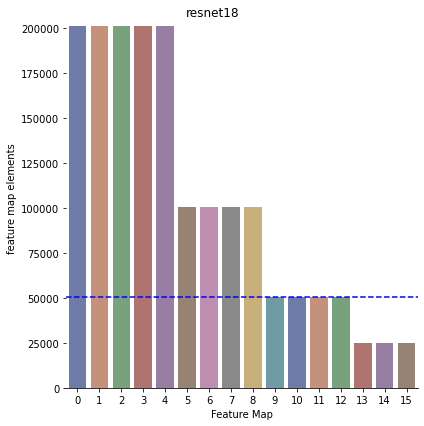

In [31]:
arch = 'resnet18'
threshold_type = 'ceiling'
threshold_fraction = 1/4
first_unsketched_idx = 100 # larger than number of layers, so all layers considered for compression
min_k_frac = 0
min_k = 0
save_configs = True

s = generate_sketch_dicts(arch, 
                      threshold_type, 
                      threshold_fraction, 
                      first_unsketched_idx, 
                      min_k,
                      min_k_frac, 
                      save_configs = save_configs)

pprint(s)

{'compression_ratios': {'ceiling_compression_ratio': '8.0x',
                        'total_compression_ratio': '2.2x'},
 'sketch_dicts': OrderedDict([(('features', 3),
                               OrderedDict([('conv', (64, 8))])),
                              (('features', 7),
                               OrderedDict([('conv', (64, 32))])),
                              (('features', 10),
                               OrderedDict([('conv', (128, 32))])),
                              (('features', 17),
                               OrderedDict([('conv', (256, 128))])),
                              (('features', 20),
                               OrderedDict([('conv', (256, 128))])),
                              (('features', 23),
                               OrderedDict([('conv', (256, 128))]))])}


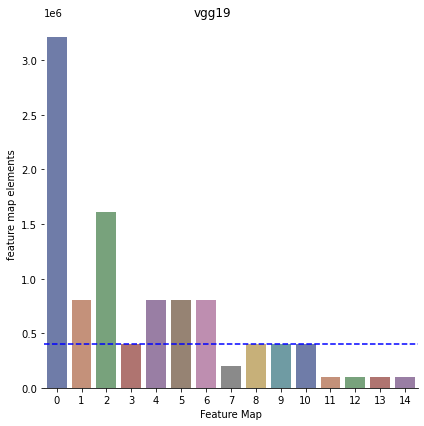

In [32]:
arch = 'vgg19'
threshold_type = 'ceiling'
threshold_fraction = 1/8
first_unsketched_idx = 100 # larger than number of layers, so all layers considered for compression
min_k_frac = 0
min_k = 0
save_configs = True

s = generate_sketch_dicts(arch, 
                      threshold_type, 
                      threshold_fraction, 
                      first_unsketched_idx, 
                      min_k,
                      min_k_frac, 
                      save_configs = save_configs)

pprint(s)

{'compression_ratios': {'ceiling_compression_ratio': '6.0x',
                        'total_compression_ratio': '2.1x'},
 'sketch_dicts': OrderedDict([(('features', 3),
                               OrderedDict([('conv', (64, 10))])),
                              (('features', 7),
                               OrderedDict([('conv', (64, 42))])),
                              (('features', 10),
                               OrderedDict([('conv', (128, 42))])),
                              (('features', 17),
                               OrderedDict([('conv', (256, 170))])),
                              (('features', 20),
                               OrderedDict([('conv', (256, 170))]))])}


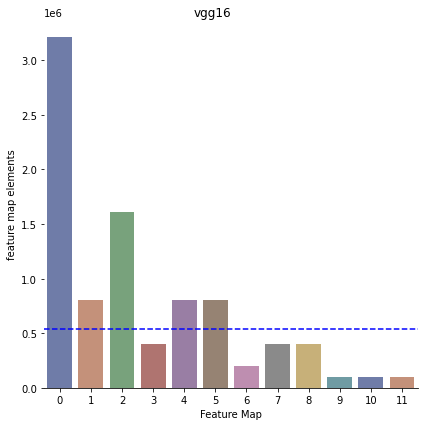

In [33]:
arch = 'vgg16'
threshold_type = 'ceiling'
threshold_fraction = 1/6
first_unsketched_idx = 100 # larger than number of layers, so all layers considered for compression
min_k_frac = 0
min_k = 0
save_configs = True

s = generate_sketch_dicts(arch, 
                      threshold_type, 
                      threshold_fraction, 
                      first_unsketched_idx, 
                      min_k,
                      min_k_frac, 
                      save_configs = save_configs)

pprint(s)